In [1]:
import os

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Activation,
    Conv2D,
    BatchNormalization,
    AveragePooling2D,
    Flatten,
    add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    ReduceLROnPlateau
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from utils import config_gpu
_ = config_gpu()

/home/youjin2/venvs/py3/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## introduction
- VAE (Variational Autoencoder) is a generative model like GAN
- But,
    - GAN focuces on the model which approximates input data distribution
    - VAE focuces on the model which can decode input data distribution on the continuous latent space
    
- VAE vs Autoencoder
    - They both learn a latent-space and try to reconstruct the input data distribution|
    - But, VAE's latent-space is continuous and decoder is used as a generative model

## notations

* $x \sim P_\theta (x)$
    - real data distribution
    - $\theta$: parameter to be learned
        - e.g.
            - face
            - hand-written number
            
* $P_\theta (x, z)$
    - join distribution of input $x$ and latent variable $z$
    - not a part of input data, but encode observable features from input data
        - e.g.
            - face data: facial expression, hair shape, hair color, sex, $\cdots$
            - mnist: number, hand-writting

## Variational Inference
* $P_\theta (x) = \int P_\theta (x, z) dz$
    - **usually intractable!**
    - Note that
\begin{align*}
P_\theta (x) &= \int P_\theta (x, z) dz \\
&= \int P_\theta (x|z) P(z) dz \quad \quad \quad \quad (1)\\
&= \int P_\theta (z|x) P(x) dz \quad \quad \quad \quad (2)\\
\end{align*}
        - (1) is inappropriate since it does not give any restrictions on $z$
        - (2) is also hard to solve
        - So, VAE aims to approximate **$P_\theta(z|x)$** while finding tractable conditional distribution (see below)

* $Q_\phi (z|x) \approx P_\theta (z|x)$
    - $Q_\phi (z|x)$ is usuaully multivariate gaussian 
    $$Q_\phi (z|x) = N(z; \mu (x), diag(\sigma (x)))$$
    
* How to measure the distance between $Q_\phi(z|x)$ and $P_\theta(z|x)$?
* $D_{KL}(Q_\phi(z|x) || P_\theta(z|x)) = E_{z\sim Q} \big[log Q_\phi(z|x) - log P_\theta (z|x) \big]$
    - $Q_\phi(z|x)$: generates $z$ from input $x$
    - $P_\theta(x|z)$: reconstruct $x$ from latent $z$
        - similiar to decoder in autoencoder

* Plugin $P_\theta (z|x) = \frac{P_\theta(x|z) P_\theta (z)}{P_\theta(x)}$ gives
    - $D_{KL}(Q_\phi(z|x) || P_\theta(z|x)) = E_{z\sim Q} \big[log Q_\phi(z|x) - log P_\theta (x|z) - log P_\theta (z)\big] + log P_\theta (x)$
    
* Re-arranging above equation gives
$$log P_\theta (x) - D_{KL}(Q_\phi(z|x) || P_\theta(z|x)) = E_{z\sim Q} \big[log P_\theta (x|z) - D_{KL} (Q_\phi (z|x) || P_\theta(z))\big]$$
    - LHS is called **variational lower bound** OR **ELBO (evidence lower bound)**

In [2]:
def lr_schedule(epoch):
    
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    
    print('Learning rate: ', lr)
    
    return lr

In [3]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    
    # for resnet v1
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    # for resnet v2
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
        
    return x

In [4]:
def resnet_v1(input_shape, depth, num_classes=10):
    
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (e.g. 20, 32, 44, ...)')
        
    # define model
    num_filters = 16
    num_res_blocks = int((depth-2)/6)
    
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    
    # residual unit
    for stack in range(3):
        # expand output filter size for each num_res_block iterations
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 & res_block == 0:
                # downsample with 1/2. for each iterations after num_res_block iterations
                strides = 2
            
            # conv-BN-Relu
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            
            # conv-BN (strides=1; preservce shapes)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            
            if stack > 0 & res_block == 0:
                # resize for shortcut-connection
                # note that
                #   - kernel_size=1 (learn CNN parameters)
                #   - strides=strides (downsample with 1/2. for each iterations after num_res_block iterations)
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
                
            # shortcut-connection
            x = add([x, y])
            x = Activation('relu')(x)
        
        # expand filter size for each num_res_block iterations
        num_filters *= 2
        
    x = AveragePooling2D(pool_size=8, padding='same')(x)
    y = Flatten()(x)
    
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

* train parameters

In [5]:
batch_size = 128
epochs = 200
data_augmentation = True
num_classes = 10

* set resnet depth

In [6]:
n = 3
depth = n*6+2

* load data

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [8]:
# normalize data.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# resacle to [-1, 1]
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean    

* build model

In [9]:
input_size = x_train.shape[1:]

In [10]:
model = resnet_v1(input_size, depth)

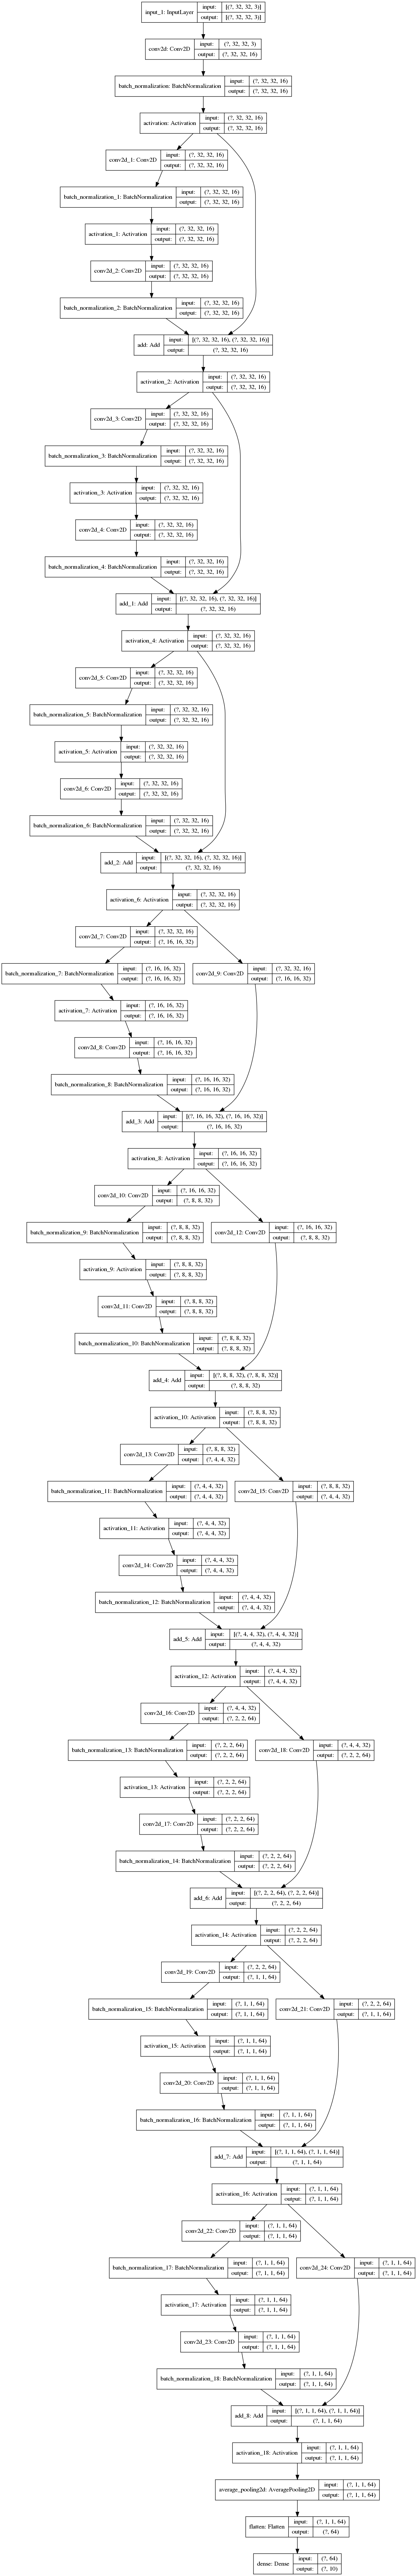

In [11]:
plot_model(model, to_file='../figures/cifar10_resnet_v1.png', show_shapes=True)

In [24]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

Learning rate:  0.001


In [13]:
# save_dir = '../models/cifar10_resnet_v1'
# os.makedirs(save_dir, exist_ok=True)

In [16]:
# # prepare callbacks for model saving and for learning rate adjustment.
# file_path = os.path.join(save_dir, 'model1')
# checkpoint = ModelCheckpoint(filepath=file_path,
#                              monitor='val_accuracy',
#                              verbose=1,
#                              save_best_only=True)

# lr_scheduler = LearningRateScheduler(lr_schedule)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

# callbacks = [checkpoint, lr_reducer, lr_scheduler]

* train model with data-augmentation

In [17]:
# # this will do preprocessing and realtime data augmentation:
# datagen = ImageDataGenerator(
#     # set input mean to 0 over the dataset
#     featurewise_center=False,
#     # set each sample mean to 0
#     samplewise_center=False,
#     # divide inputs by std of dataset
#     featurewise_std_normalization=False,
#     # divide each input by its std
#     samplewise_std_normalization=False,
#     # apply ZCA whitening
#     zca_whitening=False,
#     # randomly rotate images in the range (deg 0 to 180)
#     rotation_range=0,
#     # randomly shift images horizontally
#     width_shift_range=0.1,
#     # randomly shift images vertically
#     height_shift_range=0.1,
#     # randomly flip images
#     horizontal_flip=True,
#     # randomly flip images
#     vertical_flip=False
# )

In [18]:
# # compute quantities required for featurewise normalization
# # (std, mean, and principal components if ZCA whitening is applied).
# datagen.fit(x_train)

In [19]:
# # fit the model on the batches generated by datagen.flow().
# model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                     validation_data=(x_test, y_test),
#                     epochs=epochs, verbose=1,
#                     steps_per_epoch=len(x_train)//batch_size,
#                     callbacks=callbacks)

In [37]:
import tensorflow as tf

In [40]:
model = tf.keras.models.load_model('../models/cifar10_resnet_v1/model1/')

In [41]:
loss, acc = model.evaluate(x_test, y_test, batch_size, verbose=2)

10000/1 - 1s - loss: 0.7557 - accuracy: 0.8073


In [42]:
print('accuracy: {:01f}'.format(acc*100))

accuracy: 80.729997


## see src/resnet_v1.py

## compare resnet result with
* https://github.com/youjin2/ds029/blob/master/notebooks/01_cnn_cifar10.ipynb